In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from math import *
import time

In [2]:
torch.set_default_tensor_type('torch.DoubleTensor')

In [3]:
# activation function
def activation(x):
    return x * torch.sigmoid(x) 

# build ResNet with one blocks
class Net(nn.Module):
    def __init__(self,input_size,width):
        super(Net,self).__init__()
        self.layer_in = nn.Linear(input_size,width)
        self.layer_1 = nn.Linear(width,width)
        self.layer_2 = nn.Linear(width,width)
        self.layer_out = nn.Linear(width,1)
    def forward(self,x):
        output = self.layer_in(x)
        output = output + activation(self.layer_2(activation(self.layer_1(output)))) # residual block 1
        output = self.layer_out(output)
        return output

input_size = 1
width = 4
net = Net(input_size,width)

def model(x):
    return x * (x - 1.0) * net(x)

# exact solution
def u_ex(x):  
    return torch.sin(pi*x)

# f(x)
def f(x):
    return pi**2 * torch.sin(pi*x)

grid_num = 200
x = torch.zeros(grid_num + 1, input_size)
for index in range(grid_num + 1):
    x[index] = index * 1 / grid_num                
                
# loss function to DGM by auto differential
def loss_function(x):
    h = 1 / grid_num
    sum_0 = 0.0
    sum_1 = 0.0
    sum_2 = 0.0
    sum_a = 0.0
    sum_b = 0.0
    for index in range(grid_num):
        x_temp = x[index] + h / 2 
        x_temp.requires_grad = True
#         grad_x_temp = torch.autograd.grad(model(x_temp), x_temp, create_graph = True)
        grad_x_temp = torch.autograd.grad(outputs = model(x_temp), inputs = x_temp, grad_outputs = torch.ones(model(x_temp).shape), create_graph = True)
        grad_grad_x_temp = torch.autograd.grad(outputs = grad_x_temp[0], inputs = x_temp, grad_outputs = torch.ones(model(x_temp).shape), create_graph = True)
        sum_1 += ((grad_grad_x_temp[0])[0] + f(x_temp)[0])**2
    
    for index in range(1, grid_num):
        x_temp = x[index]
        x_temp.requires_grad = True
#         grad_x_temp = torch.autograd.grad(model(x_temp), x_temp, create_graph = True)
        grad_x_temp = torch.autograd.grad(outputs = model(x_temp), inputs = x_temp, grad_outputs = torch.ones(model(x_temp).shape), create_graph = True)
        grad_grad_x_temp = torch.autograd.grad(outputs = grad_x_temp[0], inputs = x_temp, grad_outputs = torch.ones(model(x_temp).shape), create_graph = True)
        sum_2 += ((grad_grad_x_temp[0])[0] + f(x_temp)[0])**2
    
    x_temp = x[0]
    x_temp.requires_grad = True
#     grad_x_temp = torch.autograd.grad(model(x_temp), x_temp, create_graph = True)
    grad_x_temp = torch.autograd.grad(outputs = model(x_temp), inputs = x_temp, grad_outputs = torch.ones(model(x_temp).shape), create_graph = True)
    grad_grad_x_temp = torch.autograd.grad(outputs = grad_x_temp[0], inputs = x_temp, grad_outputs = torch.ones(model(x_temp).shape), create_graph = True)
    sum_a = ((grad_grad_x_temp[0])[0] + f(x_temp)[0])**2
    
    x_temp = x[grid_num]
    x_temp.requires_grad = True
#     grad_x_temp = torch.autograd.grad(model(x_temp), x_temp, create_graph = True)
    grad_x_temp = torch.autograd.grad(outputs = model(x_temp), inputs = x_temp, grad_outputs = torch.ones(model(x_temp).shape), create_graph = True)
    grad_grad_x_temp = torch.autograd.grad(outputs = grad_x_temp[0], inputs = x_temp, grad_outputs = torch.ones(model(x_temp).shape), create_graph = True)
    sum_b = ((grad_grad_x_temp[0])[0] + f(x_temp)[0])**2
    
    sum_0 = h / 6 * (sum_a + 4 * sum_1 + 2 * sum_2 + sum_b)
    return sum_0

def error_function(x):
    error = 0.0
    for index in range(len(x)):
        x_temp = x[index]
        error += (model(x_temp)[0] - u_ex(x_temp)[0])**2
    return error / len(x)

# print("Total number of paramerters in networks is {}  ".format(sum(x.numel() for x in net.parameters())))
param_num = sum(x.numel() for x in net.parameters())

In [4]:
epoch = 10
loss_record = np.zeros((epoch, 5))
error_record = np.zeros((epoch, 5))
time_start = time.time()
for j in range(5):
    # set optimizer and learning rate decay
    optimizer = optim.Adam(net.parameters(), lr = 0.001)
    scheduler = lr_scheduler.StepLR(optimizer, 2500, 0.8) # every 2500 epoch, learning rate * 0.8
    # load model parameters
    pretrained_dict = torch.load('net_params_same_init.pkl')  
    # get state_dict
    net_state_dict = net.state_dict()
    # remove keys that does not belong to net_state_dict
    pretrained_dict_1 = {k: v for k, v in pretrained_dict.items() if k in net_state_dict}
    # update dict
    net_state_dict.update(pretrained_dict_1)
    # set new dict back to net
    net.load_state_dict(net_state_dict)
    for i in range(epoch):
        optimizer.zero_grad()
        loss = loss_function(x)
        loss_record[i, j] = float(loss)
        error = error_function(x)
        error_record[i, j] = float(error)
        print("current epoch is: ", j, i)
        print("current loss is: ", loss.detach())
        print("current error is: ", error.detach())

        loss.backward()
        optimizer.step() 
        scheduler.step()
        
time_end = time.time()
print('total time is: ', time_end-time_start, 'seconds')

current epoch is:  0 0
current loss is:  tensor(50.5345)
current error is:  tensor(0.5157)
current epoch is:  0 1
current loss is:  tensor(50.3396)
current error is:  tensor(0.5137)
current epoch is:  0 2
current loss is:  tensor(50.1453)
current error is:  tensor(0.5118)
current epoch is:  0 3
current loss is:  tensor(49.9517)
current error is:  tensor(0.5098)
current epoch is:  0 4
current loss is:  tensor(49.7588)
current error is:  tensor(0.5079)
current epoch is:  0 5
current loss is:  tensor(49.5666)
current error is:  tensor(0.5060)
current epoch is:  0 6
current loss is:  tensor(49.3751)
current error is:  tensor(0.5040)
current epoch is:  0 7
current loss is:  tensor(49.1842)
current error is:  tensor(0.5021)
current epoch is:  0 8
current loss is:  tensor(48.9940)
current error is:  tensor(0.5002)
current epoch is:  0 9
current loss is:  tensor(48.8045)
current error is:  tensor(0.4983)
current epoch is:  1 0
current loss is:  tensor(50.5345)
current error is:  tensor(0.5157)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

In [6]:
loss_record

array([[50.53451898, 50.53451898, 50.53451898, 50.53451898, 50.53451898],
       [50.33957726, 50.33957726, 50.33957726, 50.33957726, 50.33957726],
       [50.14530233, 50.14530233, 50.14530233, 50.14530233, 50.14530233],
       [49.95170615, 49.95170615, 49.95170615, 49.95170615, 49.95170615],
       [49.7587978 , 49.7587978 , 49.7587978 , 49.7587978 , 49.7587978 ],
       [49.56658218, 49.56658218, 49.56658218, 49.56658218, 49.56658218],
       [49.37505816, 49.37505816, 49.37505816, 49.37505816, 49.37505816],
       [49.18421744, 49.18421744, 49.18421744, 49.18421744, 49.18421744],
       [48.99404549, 48.99404549, 48.99404549, 48.99404549, 48.99404549],
       [48.80452464, 48.80452464, 48.80452464, 48.80452464, 48.80452464]])

In [10]:
x1 = np.linspace(0, 10, 10)
x2 = np.linspace(0, 10, 10)
x3 = np.linspace(0, 10, 10)
x4 = np.linspace(0, 10, 10)
x5 = np.linspace(0, 10, 10)

# y1 = 0.98 * loss_record[:, 0]
# y2 = 1.03 * loss_record[:, 1]
# y3 = 0.9 * loss_record[:, 2]
# y4 = 1.01 * loss_record[:, 3] 
# y5 = 1.02 * loss_record[:, 4] 

y1 = loss_record[:, 0]
y2 = loss_record[:, 1]
y3 = loss_record[:, 2]
y4 = loss_record[:, 3] 
y5 = loss_record[:, 4] 

In [11]:
data = {'Epoch': list(x1) + list(x2) + list(x3) + list(x4) + list(x5),
        'Loss': list(y1) + list(y2) + list(y3) + list(y4) + list(y5) }
df = pd.DataFrame(data)

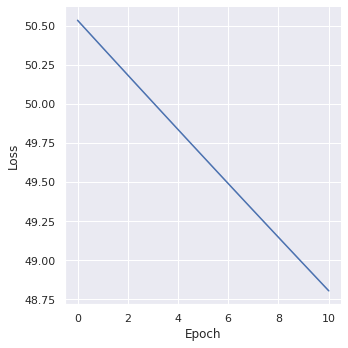

In [12]:
# 95%
sns.relplot(x = 'Epoch', y = 'Loss', kind = 'line', ci = 95, data = df)
plt.show()